In [1]:
pwd

'e:\\two_stage_model\\data_processing\\geo_processing'

In [2]:
cd ..

e:\two_stage_model\data_processing


In [3]:
%load_ext line_profiler

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
import contextily as ctx

In [5]:
country_name = 'TSMO'
model_path = 'E:/two_stage_model'

## Part 1. Read Files

In [6]:
# TMC Speed Data
df_spd = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))
speed_available_tmc_list = list(df_spd.columns)

In [7]:
speed_available_tmc_list = list(df_spd.columns)

In [8]:
# Shape
gdf_tmc_raw = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc_raw = gdf_tmc_raw.rename(columns={"tmc":"id_tmc"})

In [9]:
# neighbour info
dict_prev_tmc = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "rb"))

In [10]:
gdf_tmc_raw # for TMSO network, 1591 links totally

id_tmc     miles   direction type_x   type_y  road_order  \
0     110-12744  1.070253  SOUTHBOUND  P1.11  Feature       1.000   
1     110-07787  0.932912  SOUTHBOUND  P1.11  Feature       1.000   
2     110P11784  0.017700   WESTBOUND  P1.11  Feature       1.000   
3     110N55331  0.041891   WESTBOUND  P1.11  Feature       1.000   
4     110N53871  0.010679   WESTBOUND  P1.11  Feature       1.000   
...         ...       ...         ...    ...      ...         ...   
1586  110N06173  0.161367   EASTBOUND  P1.11  Feature      18.000   
1587  110-06174  0.135356   EASTBOUND  P1.11  Feature      19.000   
1588  110N06174  0.048057   EASTBOUND  P1.11  Feature      19.001   
1589  110-06175  0.650225   EASTBOUND  P1.11  Feature      20.000   
1590  110-06176  0.767063   EASTBOUND  P1.11  Feature      21.000   

               roadname roadnumber          county state    zip  \
0       HARPERS FARM RD        NaN          HOWARD    MD  21044   
1            HILTON PKY        NaN  BALTIMORE CITY    MD  21229   
2      OLD FREDERICK RD      MD-99          HOWARD    MD  21042   
3     EXECUTIVE PARK DR        NaN          HOWARD    MD  21045   
4     OLD MONTGOMERY RD        NaN          HOWARD    MD  21045   
...                 ...        ...             ...   ...    ...   
1586      SYKESVILLE RD      MD-32         CARROLL    MD  21784   
1587      SYKESVILLE RD      MD-32         CARROLL    MD  21784   
1588      SYKESVILLE RD      MD-32         CARROLL    MD  21784   
1589      SYKESVILLE RD      MD-32         CARROLL    MD  21784   
1590      SYKESVILLE RD      MD-32         CARROLL    MD  21784   

      start_latitude  start_longitude  end_latitude  end_longitude  \
0           39.23316        -76.89893      39.22154      -76.88850   
1           39.30835        -76.67249      39.29614      -76.67200   
2           39.30282        -76.82426      39.30281      -76.82459   
3           39.23557        -76.81382      39.23547      -76.81459   
4           39.20530        -76.82823      39.20541      -76.82837   
...              ...              ...           ...            ...   
1586        39.38106        -76.96788      39.37879      -76.96844   
1587        39.37879        -76.96844      39.37711      -76.96730   
1588        39.37711        -76.96730      39.37663      -76.96665   
1589        39.37663        -76.96665      39.36860      -76.96419   
1590        39.36860        -76.96419      39.35844      -76.96883   

                         layer  \
0         intermediate_tmc_b&h   
1         intermediate_tmc_b&h   
2         intermediate_tmc_b&h   
3         intermediate_tmc_b&h   
4         intermediate_tmc_b&h   
...                        ...   
1586  intermediate_tmc_carroll   
1587  intermediate_tmc_carroll   
1588  intermediate_tmc_carroll   
1589  intermediate_tmc_carroll   
1590  intermediate_tmc_carroll   

                                                   path  \
0     /Users/haowu/Desktop/Transportation Research/T...   
1     /Users/haowu/Desktop/Transportation Research/T...   
2     /Users/haowu/Desktop/Transportation Research/T...   
3     /Users/haowu/Desktop/Transportation Research/T...   
4     /Users/haowu/Desktop/Transportation Research/T...   
...                                                 ...   
1586  /Users/haowu/Desktop/Transportation Research/T...   
1587  /Users/haowu/Desktop/Transportation Research/T...   
1588  /Users/haowu/Desktop/Transportation Research/T...   
1589  /Users/haowu/Desktop/Transportation Research/T...   
1590  /Users/haowu/Desktop/Transportation Research/T...   

                                               geometry  
0     LINESTRING (-76.89893 39.23316, -76.89886 39.2...  
1     LINESTRING (-76.67249 39.30835, -76.67262 39.3...  
2     LINESTRING (-76.82426 39.30282, -76.82459 39.3...  
3     LINESTRING (-76.81382 39.23557, -76.81417 39.2...  
4     LINESTRING (-76.82823 39.20530, -76.82837 39.2...  
...                                                 ...  
1586  LINE

## Part 2. Generate Upstream Dict (Currently, it's for selected TMC Link Only)

In [11]:
# build link-length dictionary
Link_Length_Dict = {}

for tmc_id in list(gdf_tmc_raw['id_tmc']):
    Link_Length_Dict[tmc_id] = None
    
for tmc_id in list(gdf_tmc_raw['id_tmc']):
    Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))

C:\Users\haowu\AppData\Local\Temp\ipykernel_548020\584354739.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))
C:\Users\haowu\AppData\Local\Temp\ipykernel_548020\584354739.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))
C:\Users\haowu\AppData\Local\Temp\ipykernel_548020\584354739.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))
C:\Users\haowu\AppData\Local\Temp\ipykernel_548020\584354739.

In [12]:
# build upstream link dict
upstream_link_dict = {}
for keys in tqdm(dict_prev_tmc.keys()):
    upstream_link_dict[keys] = []
    
for keys in tqdm(dict_prev_tmc.keys()):
    new_link_list = []
    for link in dict_prev_tmc[keys]:
        new_link_list.append(link)
        upstream_link_dict[keys] = new_link_list

100%|██████████| 1502/1502 [00:00<00:00, 750517.58it/s]


In [13]:
def compute_length(link_list:list):
    length = 0
    for link in link_list:
        length += Link_Length_Dict[link]
    return length

In [14]:
# check speed_available_tmc_list
# check selected_tmc_list
def build_up_k_mile_upstream_dict(k_mile):
    element_count = 0 # count the number of route found in the whole network (for selected tmc segements only)
    upstream_k_mile_dict = {} # the final return value 
    for tmc_id in tqdm(speed_available_tmc_list): # intinal keys in the dict, we only need to know selected links info
        upstream_k_mile_dict[tmc_id] = []

    # for each selected tmc link, we have a route list, for each route, the first is the total length, the else is the link id
    # initialize the tmc link dict

    for tmc_id in tqdm(upstream_k_mile_dict.keys()):
        new_route_list = []
        for upstream_id in upstream_link_dict[tmc_id]:
            new_link_list = [compute_length([upstream_id]), upstream_id]
            new_route_list.append(new_link_list)
        element_count += len(new_route_list)
        upstream_k_mile_dict[tmc_id] = new_route_list
    
    new_element_count = 0
    while new_element_count != element_count:
        element_count = new_element_count
        new_element_count= 0
        for tmc_id in tqdm(upstream_k_mile_dict.keys()):
            new_route_list = []
            old_route_list = upstream_k_mile_dict[tmc_id]
            for route in old_route_list:
                if route[0] >= k_mile:
                    new_route_list.append(route)
                else:
                    latest_upstream_link = route[-1]
                    if latest_upstream_link in upstream_link_dict.keys():
                        for new_upstream_link in upstream_link_dict[latest_upstream_link]:
                            new_route = deepcopy(route[1:])
                            new_route.append(new_upstream_link)
                            new_route.insert(0, compute_length(new_route))
                            new_route_list.append(new_route)
                    else:
                        new_route_list.append(route)
            new_element_count += len(new_route_list)
            upstream_k_mile_dict[tmc_id] = new_route_list
    
    # delete the length indicator
    for tmc_id in upstream_k_mile_dict.keys():
        if len(upstream_k_mile_dict[tmc_id])!=0:
            for link_list in upstream_k_mile_dict[tmc_id]:
                del link_list[0]
    
    key_list = deepcopy(list(upstream_k_mile_dict.keys()))
    for tmc_id in tqdm(key_list):
        if tmc_id not in speed_available_tmc_list: # for this dict key, we do not contain the link that speed info is not available
            del upstream_k_mile_dict[tmc_id]
        else:
            upstream_route_list = deepcopy(upstream_k_mile_dict[tmc_id])
            link_list = []
            for route in upstream_route_list:
                for link in route:
                    if link in speed_available_tmc_list: # for the dict value, we only consider the link that speed info is not available
                        link_list.append(link)
            link_list = list(set(link_list))
            upstream_k_mile_dict[tmc_id] = link_list
    
    return upstream_k_mile_dict

## Part 3. Generate Downstream Dict

In [15]:
def reverse_dict(d):
    new_dict = {}
    for key, values in d.items():
        for value in values:
            if value not in new_dict:
                new_dict[value] = [key]
            else:
                new_dict[value].append(key)
    for key in new_dict.keys():
        new_dict[key] = list(set(new_dict[key]))
    return new_dict

In [16]:
downstream_link_dict = reverse_dict(upstream_link_dict)

In [18]:
# save for adjcency matrix generation
pickle.dump(downstream_link_dict, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_downstream_dict.pkl", "wb"))

In [17]:
def build_up_k_mile_downstream_dict(k_mile):
    element_count = 0 # count the number of route found in the whole network (for selected tmc segements only)
    downstream_k_mile_dict = {} # the final return value 
    for tmc_id in tqdm(downstream_link_dict.keys()): # intinal keys in the dict, we only need to know selected links info
        downstream_k_mile_dict[tmc_id] = []

    # for each selected tmc link, we have a route list, for each route, the first is the total length, the else is the link id
    # initialize the tmc link dict

    for tmc_id in tqdm(downstream_k_mile_dict.keys()):
        new_route_list = []
        for downstream_id in downstream_link_dict[tmc_id]:
            new_link_list = [compute_length([downstream_id]), downstream_id]
            new_route_list.append(new_link_list)
        element_count += len(new_route_list)
        downstream_k_mile_dict[tmc_id] = new_route_list
    
    new_element_count = 0
    while new_element_count != element_count:
        element_count = new_element_count
        new_element_count= 0
        for tmc_id in tqdm(downstream_k_mile_dict.keys()):
            new_route_list = []
            old_route_list = downstream_k_mile_dict[tmc_id]
            for route in old_route_list:
                if route[0] >= k_mile:
                    new_route_list.append(route)
                else:
                    latest_downstream_link = route[-1]
                    if latest_downstream_link in downstream_link_dict.keys():
                        for new_downstream_link in downstream_link_dict[latest_downstream_link]:
                            new_route = deepcopy(route[1:])
                            new_route.append(new_downstream_link)
                            new_route.insert(0, compute_length(new_route))
                            new_route_list.append(new_route)
                    else:
                        new_route_list.append(route)
            new_element_count += len(new_route_list)
            downstream_k_mile_dict[tmc_id] = new_route_list
    
    # delete the length indicator
    for tmc_id in downstream_k_mile_dict.keys():
        if len(downstream_k_mile_dict[tmc_id])!=0:
            for link_list in downstream_k_mile_dict[tmc_id]:
                del link_list[0]
    
    key_list = deepcopy(list(downstream_k_mile_dict.keys()))
    for tmc_id in tqdm(key_list):
        if tmc_id not in speed_available_tmc_list: # for this dict key, we do not contain the link that speed info is not available
            del downstream_k_mile_dict[tmc_id]
        else:
            downstream_route_list = deepcopy(downstream_k_mile_dict[tmc_id])
            link_list = []
            for route in downstream_route_list:
                for link in route:
                    if link in speed_available_tmc_list: # for the dict value, we only consider the link that speed info is not available
                        link_list.append(link)
            link_list = list(set(link_list))
            downstream_k_mile_dict[tmc_id] = link_list
    
    return downstream_k_mile_dict

In [18]:
upstream_k_mile_dict = build_up_k_mile_upstream_dict(2)
downstream_k_mile_dict = build_up_k_mile_downstream_dict(1)

100%|██████████| 1488/1488 [00:00<00:00, 1813.98it/s]


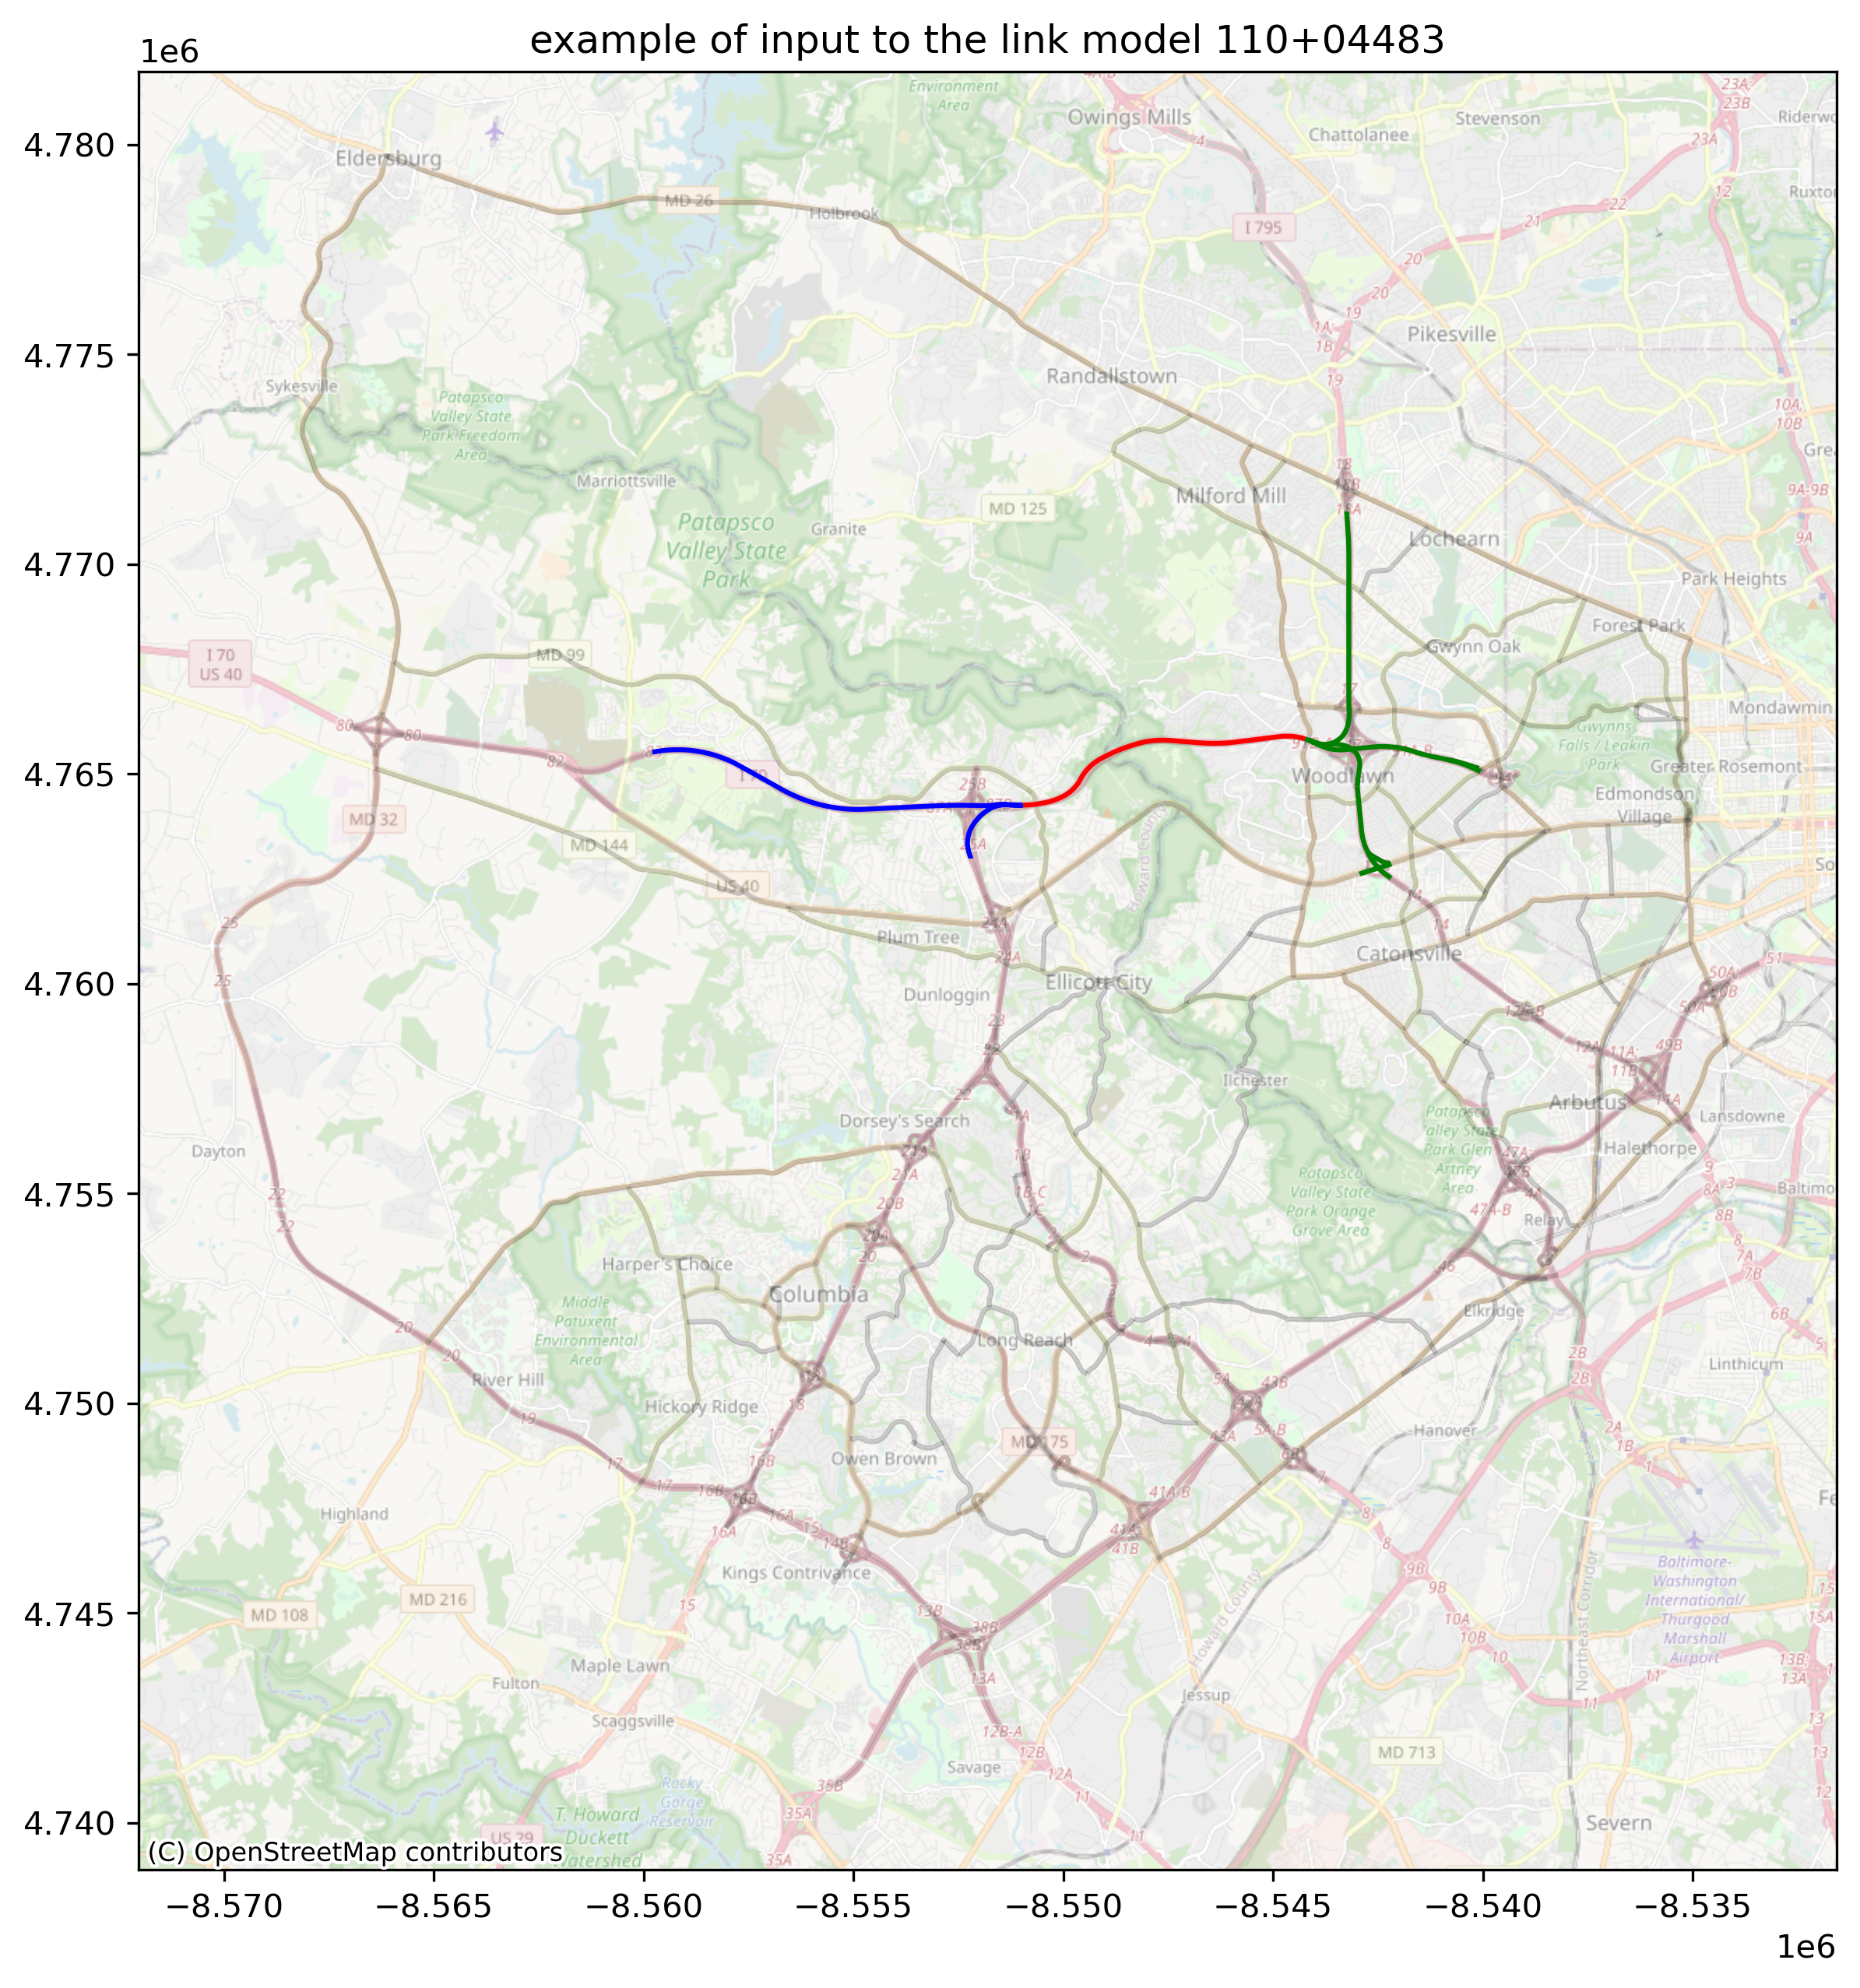

In [37]:
# Visualize TMC segments covered in different sources
gdf_shp_tmc = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_shp_tmc = gdf_shp_tmc.rename(columns={"tmc":"id_tmc"})
fig, ax = plt.subplots(1,figsize=(10,10), dpi=300)
gdf_shp_tmc = gdf_shp_tmc.to_crs(epsg=3857)

gdf_shp_tmc.plot(ax=ax, color="black", alpha = 0.1)
current_link = '110+04483'
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin([current_link])].plot(ax=ax, color="red")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(upstream_k_mile_dict[current_link])].plot(ax=ax, color="green")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(downstream_k_mile_dict[current_link])].plot(ax=ax, color="blue")
ax.set_title(f"example of input to the link model {current_link}")
gdf_shp_tmc.crs = "EPSG:4326"

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.5)
fig.savefig('down_upstream.png', dpi=300, bbox_inches='tight')

## Part 4. Save Dict

In [22]:
for upstream_range_mile in [0.0, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
    upstream_k_mile_dict = build_up_k_mile_upstream_dict(upstream_range_mile)
    upstream_range_mile= float("{:.1f}".format(upstream_range_mile))
    pickle.dump(upstream_k_mile_dict,  open(f"{model_path}/data/{country_name}/processed_data/upstream_rage_dict/{country_name}_upstream_{round(upstream_range_mile,1)}_mile.pkl", "wb"))

100%|██████████| 1431/1431 [00:00<00:00, 17976.29it/s]


In [21]:
for downstream_range_mile in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]:
    downstream_k_mile_dict = build_up_k_mile_downstream_dict(downstream_range_mile)
    downstream_range_mile= float("{:.1f}".format(downstream_range_mile))
    pickle.dump(downstream_k_mile_dict, open(f"{model_path}/data/{country_name}/processed_data/downstream_rage_dict/{country_name}_downstream_{downstream_range_mile}_mile.pkl", "wb"))

100%|██████████| 1488/1488 [00:17<00:00, 86.75it/s] 


In [23]:
float("{:.1f}".format(downstream_range_mile))

2.5